In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas
import pandas, numpy, random
import matplotlib.pyplot as plt
from pandas import Series

In [2]:
# functions to generate random data
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

In [3]:
class View(nn.Module):
    def __init__(self,shape):
        super().__init__()
        self.shape = shape,
        
    def forward(self,x):
        return x.view(*self.shape)

# Dataset Class

In [4]:
class MnistDataset(Dataset):
    def __init__(self,csv_file):
        self.data_df = pandas.read_csv(csv_file,header = 0)
        pass
    
    def  __len__(self):
        return len(self.data_df)
    
    def __getitem__(self,index):
        label = self.data_df.iloc[index,0]

        target = torch.zeros((2))
        target[label] = 1.0
        #image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:4490].values)/6108.0
        #image_values = torch.cuda.FloatTensor(image_values).view(1,1,67,67)
        
        return label,image_values,target
    
    def plot_image(self,index):
        img = self.data_df.iloc[index,1:4490].values.reshape(67,67)
        plt.title("User" + str(self.data_df.index[index])+ "  Label="+ str(self.data_df.iloc[index,0]))
        #plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img,interpolation='none',cmap = 'Blues')
        pass
    pass


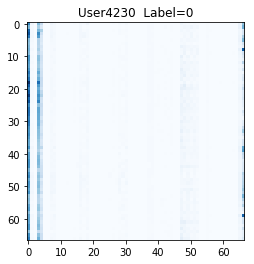

In [5]:
mnist_dataset = MnistDataset('./FullDataSet1.csv')
mnist_dataset.plot_image(4230)

# Discriminator Network 构建鉴别器

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        #define neural network layers
        self.model = nn.Sequential(
             
            nn.Linear(4489+2, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
           
        
        )
        
        self.loss_function = nn.BCELoss()
        
        self.optimiser = torch.optim.Adam(self.parameters(),lr = 0.0001)
        
        self.counter = 0;
        self.progress = []
        pass
    
    def forward(self, image_tensor, label_tensor):
        # combine seed and label
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network
        outputs = self.forward(inputs, label_tensor)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 4320 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass  

# Test Discriminator

In [7]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
#D.to(device)

for label, image_data_tensor, label_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(4489), generate_random_one_hot(2), torch.FloatTensor([0.0]))
    pass

counter =  4320
CPU times: user 3h 12min 45s, sys: 26.3 s, total: 3h 13min 11s
Wall time: 5min 53s


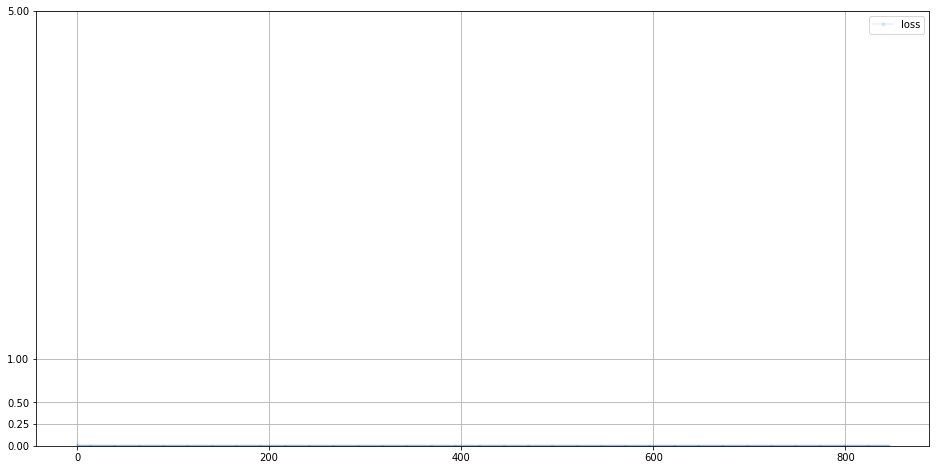

In [8]:
D.plot_progress()

In [9]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,4320)]
  print( D.forward( image_data_tensor, label_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(4489), generate_random_one_hot(2) ).item() )
  pass

0.9999887943267822
0.9999874830245972
0.9999886751174927
0.9999786615371704
1.1145625649078283e-05
1.1136296961922199e-05
1.126026199926855e-05
1.1247577276662923e-05


# Generator Network

In [10]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100+2, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 4489),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def plot_images(self, label):
        label_tensor = torch.zeros((2))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(67,67), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

# Test Generator Output

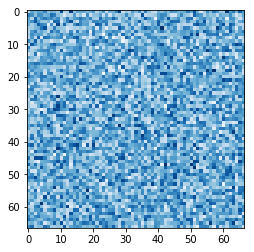

In [11]:
# check the generator output is of the right type and shape

G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(2))

img = output.detach().numpy().reshape(67,67)

plt.imshow(img, interpolation='none', cmap='Blues')

# Train GAN

In [12]:
# train Discriminator and Generator

D = Discriminator()
G = Generator()
# D.to(device)
# G.to(device)

In [13]:
%%time 

# train Discriminator and Generator

epochs = 100

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for label, image_data_tensor, label_tensor in mnist_dataset:
    # train discriminator on true
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    # random 1-hot label for generator
    random_label = generate_random_one_hot(2)
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    
    # different random 1-hot label for generator
    random_label = generate_random_one_hot(2)

    # train generator
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  4320
epoch =  2
counter =  8640
counter =  12960
epoch =  3
counter =  17280
counter =  21600
epoch =  4
counter =  25920
counter =  30240
epoch =  5
counter =  34560
counter =  38880
epoch =  6
counter =  43200
counter =  47520
epoch =  7
counter =  51840
counter =  56160
epoch =  8
counter =  60480
counter =  64800
epoch =  9
counter =  69120
counter =  73440
epoch =  10
counter =  77760
counter =  82080
epoch =  11
counter =  86400
counter =  90720
epoch =  12
counter =  95040
counter =  99360
epoch =  13
counter =  103680
counter =  108000
epoch =  14
counter =  112320
counter =  116640
epoch =  15
counter =  120960
counter =  125280
epoch =  16
counter =  129600
counter =  133920
epoch =  17
counter =  138240
counter =  142560
epoch =  18
counter =  146880
counter =  151200
epoch =  19
counter =  155520
counter =  159840
epoch =  20
counter =  164160
counter =  168480
epoch =  21
counter =  172800
counter =  177120
epoch =  22
counter =  181440
counter =  185

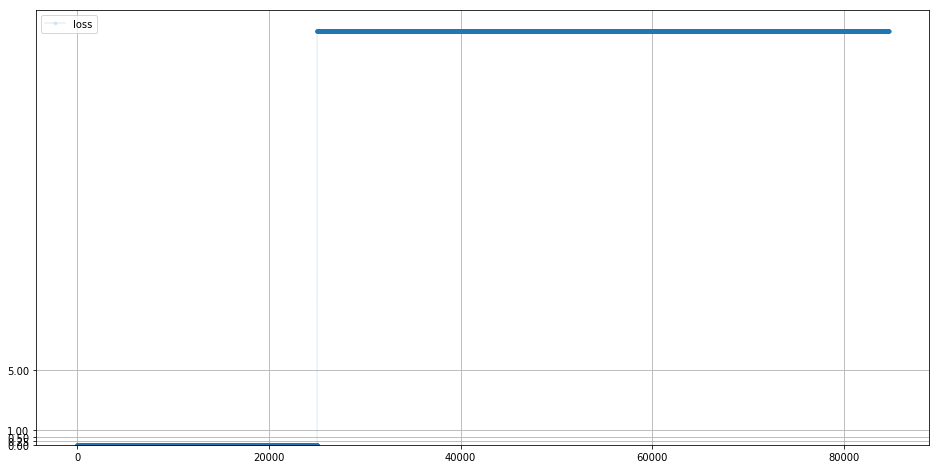

In [14]:
# plot discriminator error

D.plot_progress()

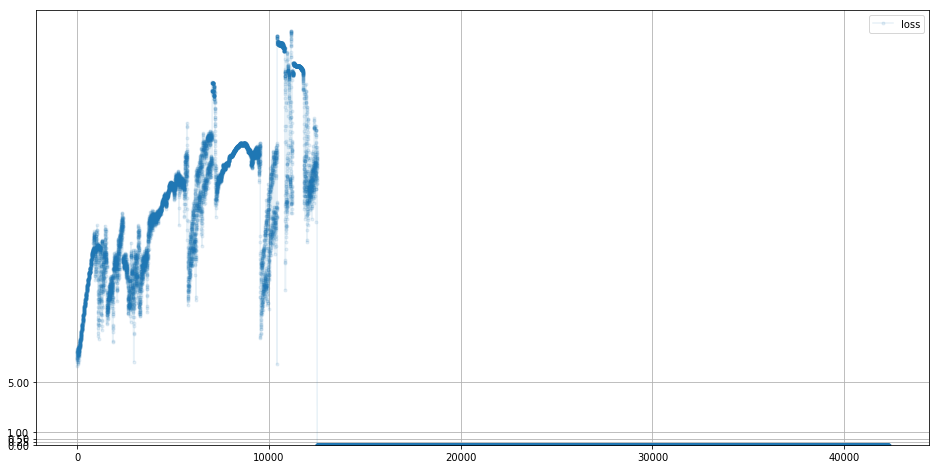

In [15]:
# plot generator error

G.plot_progress()

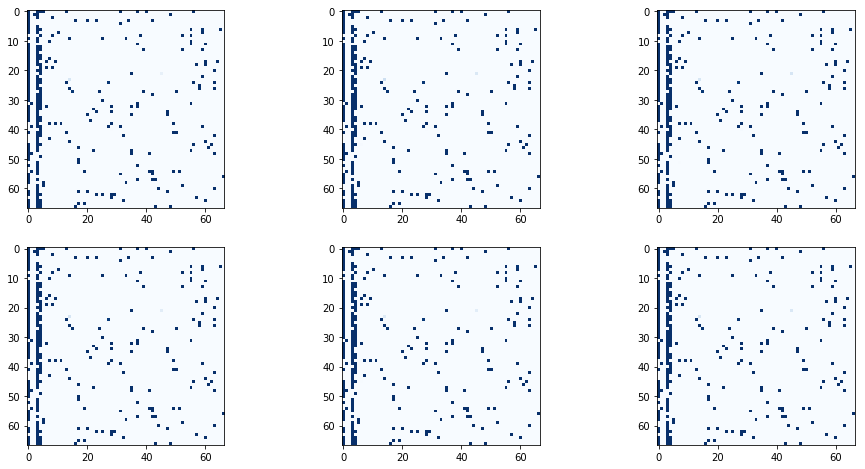

In [16]:
# plot several outputs from the trained generator

G.plot_images(1)

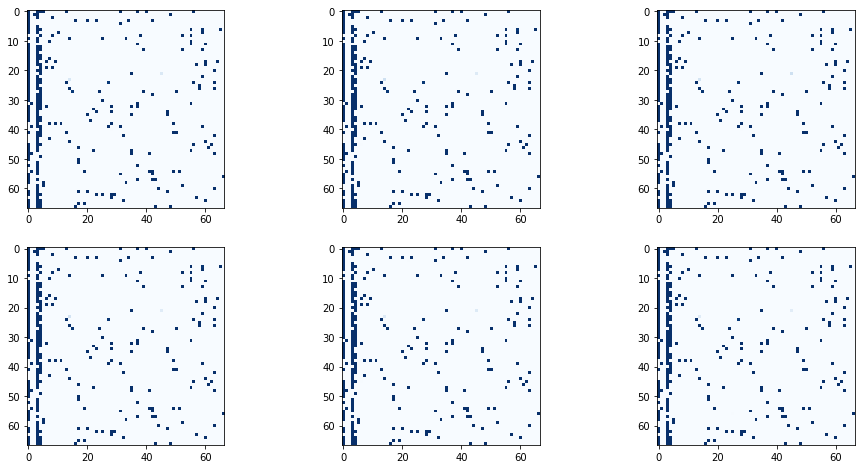

In [17]:
# plot several outputs from the trained generator

G.plot_images(0)

In [38]:
output1 = G.forward(generate_random_seed(100),torch.tensor([1., 0.]))

In [39]:
output0 = G.forward(generate_random_seed(100),torch.tensor([0., 1.]))

In [35]:
output0.reshape(67,67)

tensor([[9.9984e-01, 3.2524e-13, 1.6314e-13,  ..., 1.5655e-09, 1.5192e-13,
         8.5101e-07],
        [1.0000e+00, 2.9974e-13, 9.9936e-01,  ..., 3.2242e-04, 6.2480e-07,
         2.0844e-05],
        [9.9994e-01, 3.8552e-05, 1.1419e-13,  ..., 2.7346e-09, 7.3551e-05,
         3.0825e-05],
        ...,
        [1.0000e+00, 7.3911e-05, 9.3338e-13,  ..., 1.1399e-07, 3.7541e-07,
         1.8566e-11],
        [9.9993e-01, 9.8025e-05, 7.3597e-15,  ..., 2.9395e-13, 3.0482e-05,
         2.0108e-07],
        [9.9976e-01, 6.2267e-05, 1.6455e-13,  ..., 3.4690e-05, 6.6596e-07,
         8.9708e-07]], grad_fn=<ViewBackward>)

In [41]:
x = (output1-output0).reshape(67,67)

In [42]:
x

tensor([[ 1.0091e-04, -1.5995e-13, -3.6796e-14,  ..., -8.4659e-10,
          4.1855e-14,  1.7263e-07],
        [ 1.1921e-07, -2.3056e-13,  2.7180e-04,  ...,  1.3450e-04,
          6.1123e-08, -7.9313e-07],
        [ 3.8147e-06, -4.3156e-07, -7.3738e-15,  ...,  5.7074e-10,
          9.6267e-05, -4.3974e-07],
        ...,
        [ 0.0000e+00,  2.9432e-05, -3.5934e-13,  ..., -3.2847e-08,
         -8.7789e-09, -4.1167e-12],
        [ 1.0014e-05,  3.8055e-05, -2.7967e-15,  ..., -5.7756e-14,
          1.7565e-05, -8.5555e-08],
        [-2.2292e-05,  8.4408e-06, -1.3018e-13,  ..., -1.5499e-06,
          3.2040e-08, -7.4460e-08]], grad_fn=<ViewBackward>)